In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
ztf_fields1 = ztf_fields[:906]
ztf_fields2 = ztf_fields[906:]
bins = SurveyFieldBins(ra=ztf_fields1[:,1], dec=ztf_fields1[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 6.86 degrees for now
# There is more field overlap the closer you get to the poles

In [3]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import simsurvey.cadence as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(400.) # Tuned to give 1% flux error at R=18 in combination with gain=0.25 
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields1[:,1], dec=ztf_fields1[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f15a7974a10>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x7f15a75d9d88>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f15a7707a90>,
 'figure': <matplotlib.figure.Figure at 0x7f15bbb374d0>}

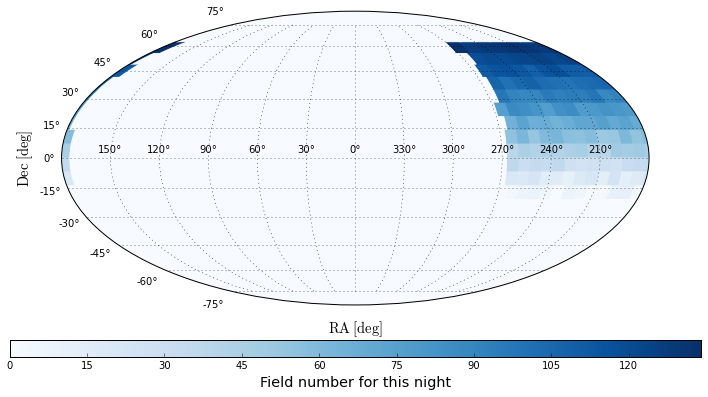

In [4]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f15a765a290>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x7f15a75e61b8>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f15a76f8f50>,
 'figure': <matplotlib.figure.Figure at 0x7f15bbb1ad50>}

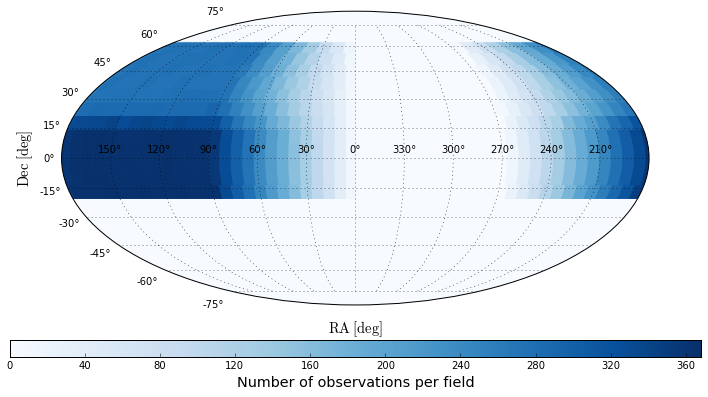

In [5]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [6]:
tr = simul.get_sn_generator([0.01,0.1], ratekind="basic", 
                            mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f15a5bf4f10>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x7f15a74fe290>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f15a74fba90>,
 'figure': <matplotlib.figure.Figure at 0x7f15bbb372d0>}

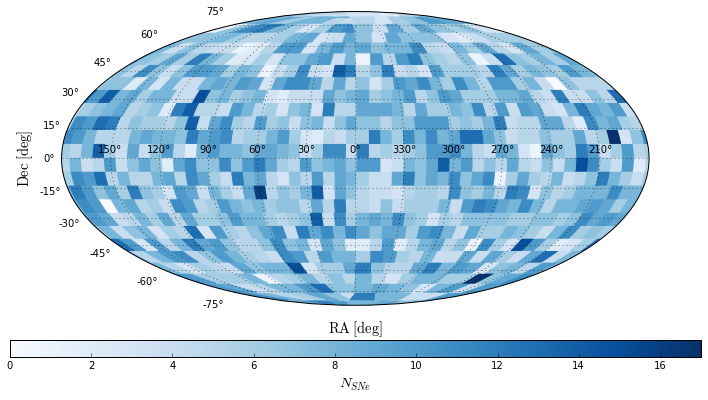

In [7]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1476 out of 6083


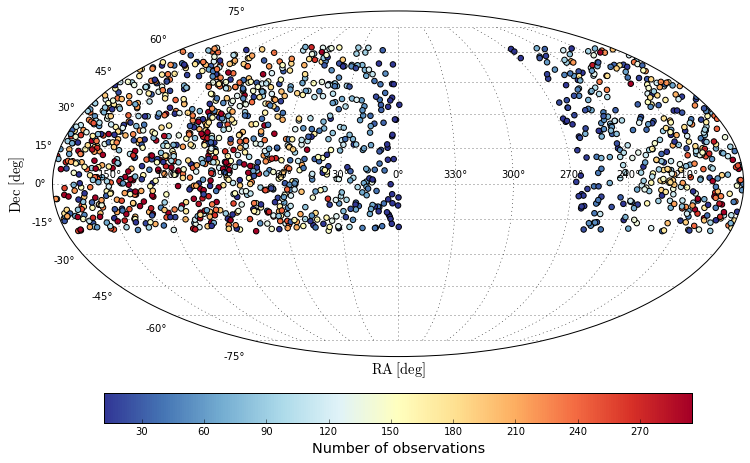

In [8]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":0.25,"zp":30,"zpsys":'ab'},
            "desr":{"gain":0.25,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()

idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=idx)
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [9]:
# example lightcurve
lcs[0]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,int64,str2
58029.0493056,desr,240639.267248,1059.40628183,30,ab
58029.1451389,desg,294737.604424,1157.23072577,30,ab
58029.2409722,desr,245261.091591,1069.98084824,30,ab
58030.0506944,desr,267613.161982,1110.048511,30,ab
58030.1458333,desg,331798.582382,1218.83261597,30,ab
58030.2409722,desr,272856.272683,1118.44130127,30,ab
58031.0506944,desr,291704.024016,1149.62865472,30,ab
58031.1458333,desg,362511.458934,1269.36457751,30,ab
58031.2409722,desr,295249.735159,1155.8832941,30,ab


In [10]:
# Its parameters
lcs[0].meta

{'c': -0.13555923992375105,
 'dec': 15.705281346261797,
 'idx_orig': 2,
 'mwebv': 0.034526666023736947,
 'mwebv_sfd98': 0.037475116550922394,
 'ra': 114.75089075345483,
 't0': 58035.955000413116,
 'x0': 0.0081318928357419218,
 'x1': -0.83421008880538461,
 'z': 0.02631401810065169}

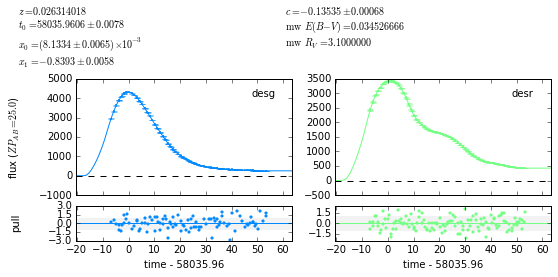

In [11]:
# Example lightcurve fit
lc = lcs[0]

import sncosmo
survey.generator.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.generator.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f15a59e1550>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x7f15a57f6b90>,
 'figure': <matplotlib.figure.Figure at 0x7f15a59e1750>,
 'plot': <matplotlib.collections.PathCollection at 0x7f15a5a28f90>}

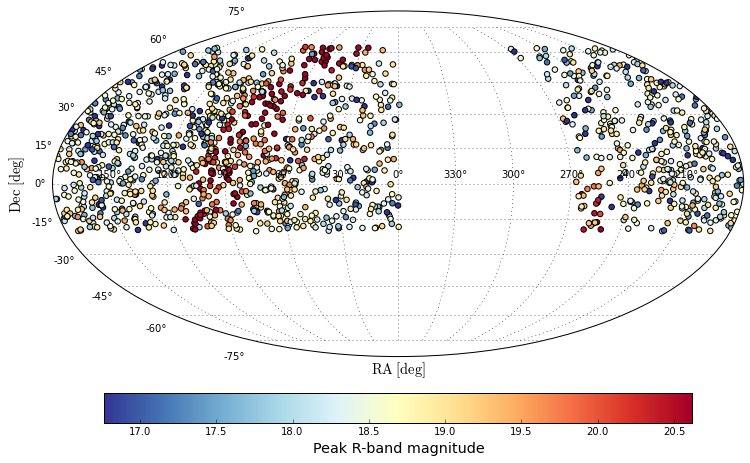

In [12]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.generator.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", mask=(n_obs > 0))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f15a598ff50>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x7f15a4f5add0>,
 'figure': <matplotlib.figure.Figure at 0x7f15a5b12a10>,
 'plot': <matplotlib.collections.PathCollection at 0x7f15a4eba890>}

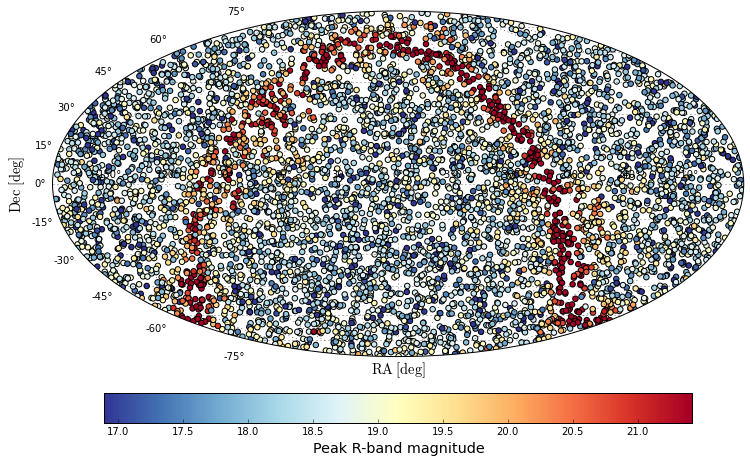

In [13]:
# It's more obvious when using the whole sample
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude")